In [7]:
'''
from "Generating Long Sequences with Sparse Transformers" (https://arxiv.org/pdf/1904.10509)
note you won't see a speedup running this since GPUs still do the full dense matmul 
this is why you need sparse CUDA kernels to tell the GPU that the full matmul is not needed
and they do this in the paper, but its out of scope for this implementation of the core idea 
'''
import torch 
from torch import nn
import torch.nn.functional as F


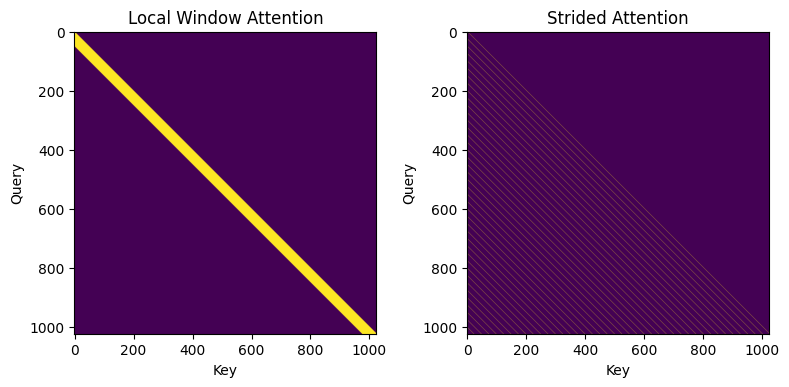

torch.Size([8, 1024, 512])

In [ ]:
# variant 1 from the paper, where they hardcode two head attention patterns
# one head is local sliding window attention
# the other is globally strided 
class StridedAttention(nn.Module): 
    def __init__(self, D=512, stride=3, window=10):
        super().__init__()
        self.D = D
        self.wq = nn.Linear(D,D)
        self.wk = nn.Linear(D,D)
        self.wv = nn.Linear(D,D)
        self.wo = nn.Linear(D,D)
        
        self.head_dim = D//2 # hardcode two attn heads, as in the paper 
        self.n_heads = D//self.head_dim 
        self.stride = stride
        self.window = window

    def forward(self, x, plot=False): # BSD -> BSD 
        B, S, D = x.shape
        
        q, k, v = self.wq(x), self.wk(x), self.wv(x) # BSD -> BSD

        # view as B, n_heads, S, head_dim
        q = q.view(B, self.n_heads, S, self.head_dim)
        k = k.view(B, self.n_heads, S, self.head_dim)
        v = v.view(B, self.n_heads, S, self.head_dim)
    
        scores = torch.einsum('bnqd,bnkd->bnqk', q, k) # [batch, nheads, seq, seq] 
        
        # KEY SPARSE ATTN COMPUTATIONS
        causal_mask = torch.arange(S, device=x.device)[:, None] >= torch.arange(S, device=x.device)
        stride_mask = (torch.arange(S, device=x.device)[:, None] - torch.arange(S, device=x.device)) % self.stride == 0
        local_diff = torch.arange(S, device=x.device)[:, None] - torch.arange(S, device=x.device)
        
        local_mask = (local_diff >= 0) & (local_diff < self.window) & causal_mask 
        strided_mask = stride_mask & causal_mask 

        # expand masks to batch dimension and add head dimension
        local_mask = local_mask.unsqueeze(0).unsqueeze(0).expand(B, 1, S, S)  # [B, 1, S, S]
        strided_mask = strided_mask.unsqueeze(0).unsqueeze(0).expand(B, 1, S, S)  # [B, 1, S, S]
        
        # combine masks for both heads
        overall_mask = torch.cat([local_mask, strided_mask], dim=1)  # [B, 2, S, S]
        masked_scores = torch.where(overall_mask, scores, torch.tensor(float('-inf'), device=scores.device))
        A = F.softmax(masked_scores/(self.head_dim ** 0.5), dim=-1)

        # helper for visualization so we can see attn masks in action 
        if plot:
            import matplotlib.pyplot as plt
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
            
            ax1.imshow(local_mask[0,0].cpu())
            ax1.set_title('Local Window Attention')
            ax1.set_xlabel('Key')
            ax1.set_ylabel('Query')
            
            ax2.imshow(strided_mask[0,0].cpu())
            ax2.set_title('Strided Attention')
            ax2.set_xlabel('Key') 
            ax2.set_ylabel('Query')
            
            plt.tight_layout()
            plt.show()

        # sanity checks that attn looks like we want it to 
        assert torch.allclose(A.sum(dim=-1), torch.ones_like(A.sum(dim=-1))), "Attention weights don't sum to 1"
        assert torch.all((A > 0) == overall_mask), "Attention weights don't match mask pattern"
        # END KEY SPARSE ATTN COMPUTATIONS

        out = torch.einsum('bnqk,bnkd->bnqd', A, v)
        # reshape from [batch, n_heads, seq, head_dim] back to [batch, seq, dim], this cats head outputs
        out = out.view(B, S, D)
        
        return self.wo(out)

attn = StridedAttention(stride=25, window=50)
B, S, D = 8, 1024, 512
x = torch.randn(B, S, D)
attn(x, plot=True).shape

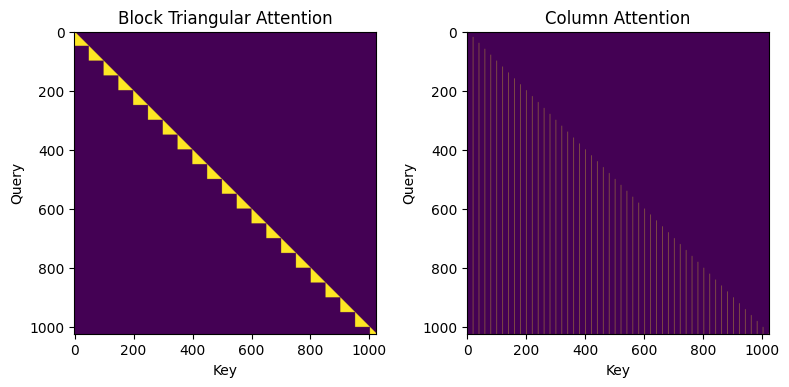

torch.Size([8, 1024, 512])

In [ ]:
# Variant 2 from the paper, where they hardcode two head attention patterns
# One head is triangular block sparse attention
# The other is columnar attention on a few tokens
class FixedSparseAttention(nn.Module): 
    def __init__(self, D=512, block_sz=5, col_stride=10):
        super().__init__()
        self.D = D
        self.wq = nn.Linear(D,D)
        self.wk = nn.Linear(D,D)
        self.wv = nn.Linear(D,D)
        self.wo = nn.Linear(D,D)
        
        self.head_dim = D//2
        self.n_heads = D//self.head_dim 
        self.block_sz = block_sz
        self.col_stride = col_stride

    # rememner, we also need to include causal mask 
    def forward(self, x, plot=False): # BSD -> BSD 
        B, S, D = x.shape
        
        q, k, v = self.wq(x), self.wk(x), self.wv(x) # BSD -> BSD

        # view as B, n_heads, S, head_dim
        q = q.view(B, self.n_heads, S, self.head_dim)
        k = k.view(B, self.n_heads, S, self.head_dim)
        v = v.view(B, self.n_heads, S, self.head_dim)
    
        scores = torch.einsum('bnqd,bnkd->bnqk', q, k) # [batch, nheads, seq, seq] 
        
        # KEY SPARSE ATTN COMPUTATIONS
        # a "block triangular mask" like in the paper is just block diagonal + causal 
        num_blocks = (S + self.block_sz - 1) // self.block_sz  # Ceiling division
        last_block_size = S - (num_blocks - 1) * self.block_sz
        blocks = [torch.ones(self.block_sz, self.block_sz, device=x.device) for _ in range(num_blocks - 1)]
        blocks.append(torch.ones(last_block_size, last_block_size, device=x.device))
        block_mask = torch.block_diag(*blocks).bool() # reading torch docs is key because it's important 
        # to know functions like block_diag (other niche but important ones include things like scatter/gather/interleave/pad)

        causal_mask = torch.arange(S, device=x.device)[:, None] >= torch.arange(S, device=x.device)
        
        # First head: block diagonal + causal
        block_causal_mask = block_mask & causal_mask
        
        # Second head: strided columns + causal 
        col_mask = (0 * torch.arange(S, device=x.device)[:, None] + torch.arange(S, device=x.device)) % self.col_stride == 0
        col_causal_mask = col_mask & causal_mask

        # expand masks to batch dimension and add head dimension so we can match dims of scores
        block_causal_mask = block_causal_mask.unsqueeze(0).unsqueeze(0).expand(B, 1, S, S)
        col_causal_mask = col_causal_mask.unsqueeze(0).unsqueeze(0).expand(B, 1, S, S)
        
        # combine masks to match dim of scores, mask out using torch.where
        overall_mask = torch.cat([block_causal_mask, col_causal_mask], dim=1)
        masked_scores = torch.where(overall_mask, scores, torch.tensor(float('-inf'), device=scores.device))
        A = F.softmax(masked_scores/(self.head_dim ** 0.5), dim=-1)

        if plot:
            import matplotlib.pyplot as plt
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
            
            ax1.imshow(block_causal_mask[0,0].cpu())
            ax1.set_title('Block Triangular Attention')
            ax1.set_xlabel('Key')
            ax1.set_ylabel('Query')
            
            ax2.imshow(col_causal_mask[0,0].cpu())
            ax2.set_title('Column Attention')
            ax2.set_xlabel('Key') 
            ax2.set_ylabel('Query')
            
            plt.tight_layout()
            plt.show()

        # sanity checks 
        assert torch.allclose(A.sum(dim=-1), torch.ones_like(A.sum(dim=-1))), "Attention weights don't sum to 1"
        assert torch.all((A > 0) == overall_mask), "Attention weights don't match mask pattern"
        # END KEY SPARSE ATTN COMPUTATIONS

        out = torch.einsum('bnqk,bnkd->bnqd', A, v)
        # reshape from [batch, n_heads, seq, head_dim] back to [batch, seq, dim], this cats head outputs
        out = out.view(B, S, D)
        
        return self.wo(out)

block_sz = 50
col_stride = 20
B, S, D = 8, 1024, 512
attn = FixedSparseAttention(D, block_sz=block_sz, col_stride=col_stride)
x = torch.randn(B, S, D)
attn(x, plot=True).shape

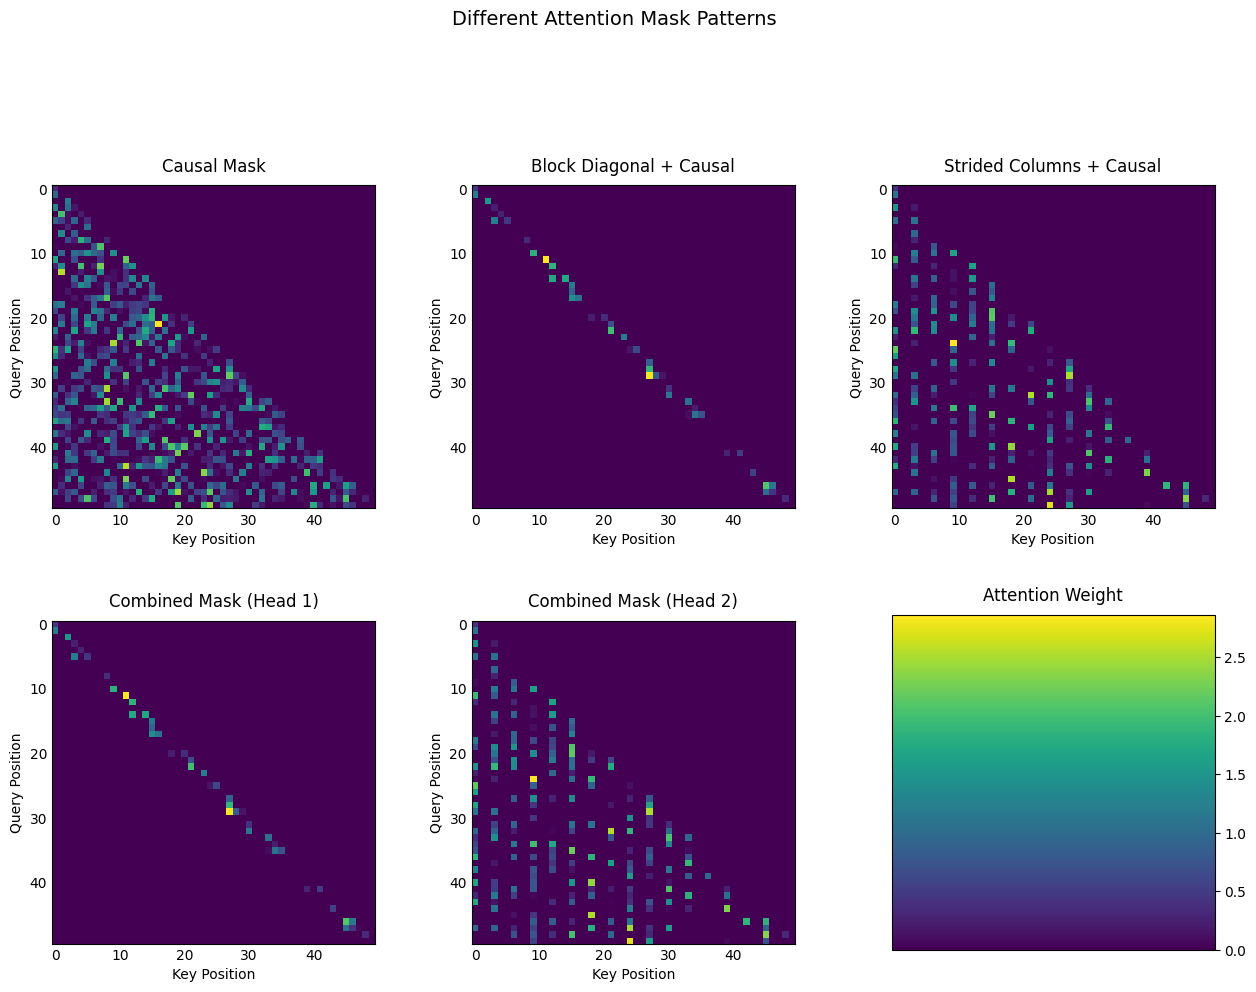

In [10]:
import matplotlib.pyplot as plt

# a cute little mask playground for me and you to figure out the mask generation logic 
# so we can construct and use the right sparse masks in forward() methods above
def plot_masks():
    n = 50
    A = torch.randn(n, n)
    
    fig = plt.figure(figsize=(15, 10))
    # Use y parameter instead of pad which is not supported
    fig.suptitle('Different Attention Mask Patterns', fontsize=14, y=1.05)
    
    # Set up grid of subplots, 2 rows 3 cols
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # causal
    ax1 = fig.add_subplot(gs[0, 0])
    causal_mask = torch.arange(n)[:, None] >= torch.arange(n)
    im1 = ax1.imshow(A * causal_mask, cmap='viridis', vmin=0)
    ax1.set_title('Causal Mask', pad=10)
    
    # block diagonal + causal
    ax2 = fig.add_subplot(gs[0, 1])
    block_sz = 3
    num_blocks = (n + block_sz - 1) // block_sz
    last_block_size = n - (num_blocks - 1) * block_sz
    blocks = [torch.ones(block_sz, block_sz) for _ in range(num_blocks - 1)]
    blocks.append(torch.ones(last_block_size, last_block_size))
    block_mask = torch.block_diag(*blocks).bool()
    block_causal_mask = block_mask & causal_mask
    im2 = ax2.imshow(A * block_causal_mask, cmap='viridis', vmin=0)
    ax2.set_title('Block Diagonal + Causal', pad=10)
    
    # strided columns + causal
    ax3 = fig.add_subplot(gs[0, 2])
    stride = 3
    col_mask = (0 * torch.arange(n)[:, None] + torch.arange(n)) % stride == 0
    col_causal_mask = col_mask & causal_mask
    im3 = ax3.imshow(A * col_causal_mask, cmap='viridis', vmin=0)
    ax3.set_title('Strided Columns + Causal', pad=10)
    
    # combined masks
    ax4 = fig.add_subplot(gs[1, 0])
    combined_mask = torch.stack([block_causal_mask, col_causal_mask])
    im4 = ax4.imshow(A * combined_mask[0], cmap='viridis', vmin=0)
    ax4.set_title('Combined Mask (Head 1)', pad=10)
    
    ax5 = fig.add_subplot(gs[1, 1])
    im5 = ax5.imshow(A * combined_mask[1], cmap='viridis', vmin=0)
    ax5.set_title('Combined Mask (Head 2)', pad=10)
    
    # Add colorbar to the right of the last plot
    cbar_ax = fig.add_subplot(gs[1, 2])
    plt.colorbar(im1, cax=cbar_ax)
    cbar_ax.set_title('Attention Weight', pad=10)
    
    # Style all subplots
    for ax in [ax1, ax2, ax3, ax4, ax5]:
        ax.set_xlabel('Key Position')
        ax.set_ylabel('Query Position')
        ax.grid(False)
        # Remove ticks but keep labels
        ax.tick_params(length=0)
    
    plt.show()

plot_masks()
